In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


0.09508416477912512


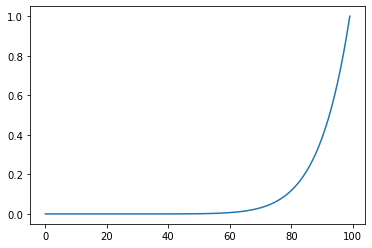

In [94]:
x = numpy.linspace(0,1,100)
y = x**10
print(numpy.mean(y))
plt.plot(y)

python_version() --->  3.8.2
torch.__version__ -->  1.6.0
Dataset lenght: 50
img.shape torch.Size([50, 1, 80, 80])
img.dtype torch.float32
img.device cpu
MINIBATCH: img.shapes seg.shape labels.shape, index.shape -> torch.Size([8, 1, 80, 80]) torch.Size([8, 1, 80, 80]) torch.Size([8]) torch.Size([8])
MINIBATCH: min and max of minibatch tensor(0.) tensor(1.)


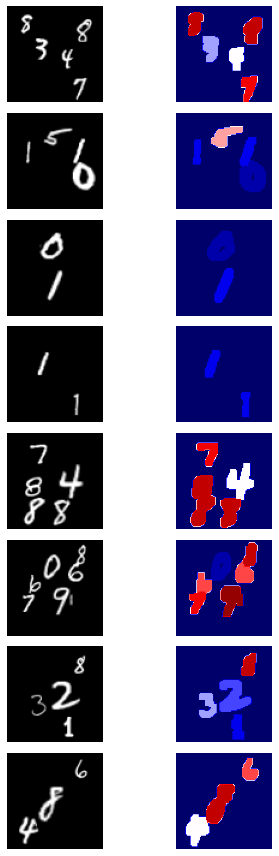

In [4]:
import neptune
from MODULES.utilities_neptune import log_object_as_artifact, log_model_summary, log_img_only
from MODULES.utilities_neptune import log_dict_metrics, log_concordance
from MODULES.vae_model import *
from MODULES.utilities_visualization import show_batch, plot_tiling, plot_all_from_dictionary, plot_label_contours
from MODULES.utilities_visualization import plot_reconstruction_and_inference, plot_generation, plot_segmentation
from MODULES.utilities_visualization import plot_img_and_seg, plot_concordance
from MODULES.utilities_ml import ConditionalRandomCrop, SpecialDataSet, process_one_epoch
# from MODULES.graph_clustering import GraphSegmentation
from MODULES.utilities import QC_on_integer_mask, concordance_integer_masks, load_json_as_dict
# import skimage.io

# Check versions
import torch
import numpy
from platform import python_version
print("python_version() ---> ", python_version())
print("torch.__version__ --> ", torch.__version__)

# make sure to fix the randomness at the very beginning
torch.manual_seed(0)
numpy.random.seed(0)

params = load_json_as_dict("./ML_parameters.json")

# Get the training and test data
img_train, seg_mask_train, count_train = load_obj("./data_train.pt")
img_test, seg_mask_test, count_test = load_obj("./data_test.pt")
BATCH_SIZE = params["simulation"]["batch_size"]

train_loader = SpecialDataSet(img=img_train,
                              roi_mask=None,
                              seg_mask=seg_mask_train,
                              labels=count_train,
                              batch_size=BATCH_SIZE,
                              drop_last=False,
                              shuffle=True)

train_loader.check_batch()

Dataset lenght: 50
img.shape torch.Size([50, 1, 80, 80])
img.dtype torch.float32
img.device cpu
MINIBATCH: img.shapes seg.shape labels.shape, index.shape -> torch.Size([8, 1, 80, 80]) torch.Size([8, 1, 80, 80]) torch.Size([8]) torch.Size([8])
MINIBATCH: min and max of minibatch tensor(0.) tensor(1.)


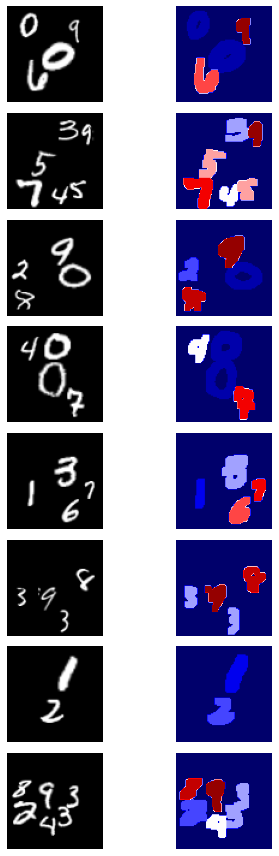

In [5]:
test_loader = SpecialDataSet(img=img_test,
                             roi_mask=None,
                             seg_mask=seg_mask_test,
                             labels=count_test,
                             batch_size=BATCH_SIZE,
                             drop_last=False,
                             shuffle=False)

test_loader.check_batch()

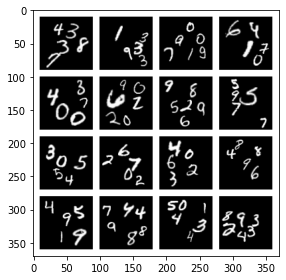

In [8]:
# Instantiate model, optimizer and checks
vae = CompositionalVae(params)
optimizer = instantiate_optimizer(model=vae, dict_params_optimizer=params["optimizer"])
          
# Make reference images
index_tmp = torch.arange(test_loader.img.shape[0])[:128]
tmp_imgs, tmp_seg, tmp_count = test_loader.load(index=index_tmp)[:3]
mask = (tmp_count == 6) + (tmp_count == 5)
reference_imgs = tmp_imgs[mask][:16]
reference_seg = tmp_seg[mask][:16]
reference_count = tmp_count[mask][:16]
show_batch(reference_imgs, normalize_range=(0.0, 1.0))

# Restart simulation

In [9]:
#ckpt = file2ckpt(path="ckpt.pt", device=None)
ckpt = file2ckpt(path="ckpt.pt", device='cpu')

load_from_ckpt(ckpt=ckpt,
               model=vae,
               optimizer=optimizer,
               overwrite_member_var=True)

epoch_restart = ckpt.get('epoch', -1)
history_dict = ckpt.get('history_dict', {})
try:
    min_test_loss = min(history_dict.get("test_loss", 999999))
except:
    min_test_loss = 999999

In [13]:
epoch = 0
vae.train()
vae.topk_only = False
train_metrics = process_one_epoch(model=vae, 
                                  noisy_sampling=True,
                                  topk_only=vae.topk_only,
                                  dataloader=train_loader,
                                  optimizer=optimizer, 
                                  verbose=(epoch == 0),
                                  weight_clipper=None)

i =   0 train_loss=0.76886


In [30]:
index = train_metrics.wrong_examples
imgs_error, seg_error, count_error, index_2 = train_loader.load(index=torch.from_numpy(index))

[ 1 29 11 48 25 31 40 49]
tensor([ 1, 29, 11, 48, 25, 31, 40, 49])


In [81]:
output_03 = vae.process_batch_imgs(imgs_in=imgs_error,
                                generate_synthetic_data=False,
                                topk_only=False,
                                draw_image=True,
                                draw_bg=True,
                                draw_boxes=True,
                                verbose=False,
                                noisy_sampling=True,
                                prob_corr_factor=0.0,
                                overlap_threshold=0.3,
                                n_objects_max=10)

output_05 = vae.process_batch_imgs(imgs_in=imgs_error,
                                generate_synthetic_data=False,
                                topk_only=False,
                                draw_image=True,
                                draw_bg=True,
                                draw_boxes=True,
                                verbose=False,
                                noisy_sampling=True,
                                prob_corr_factor=0.0,
                                overlap_threshold=0.5,
                                n_objects_max=10)


output_07 = vae.process_batch_imgs(imgs_in=imgs_error,
                                generate_synthetic_data=False,
                                topk_only=False,
                                draw_image=True,
                                draw_bg=True,
                                draw_boxes=True,
                                verbose=False,
                                noisy_sampling=True,
                                prob_corr_factor=0.0,
                                overlap_threshold=0.7,
                                n_objects_max=10)

tensor([ 0.,  0.,  0., -2.,  0., -1.,  0.,  0.], grad_fn=<SubBackward0>)


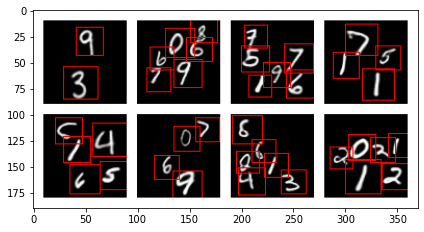

In [89]:
print(output_03.inference.sample_c.sum(dim=0) - count_error)
show_batch(output_03.imgs)

tensor([0., 0., 0., 0., 0., 0., 0., 0.], grad_fn=<SubBackward0>)


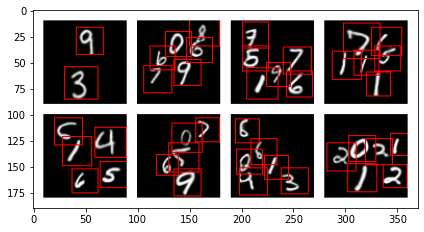

In [90]:
print(output_05.inference.sample_c.sum(dim=0) - count_error)
show_batch(output_05.imgs)

tensor([0., 0., 0., 0., 0., 0., 0., 0.], grad_fn=<SubBackward0>)


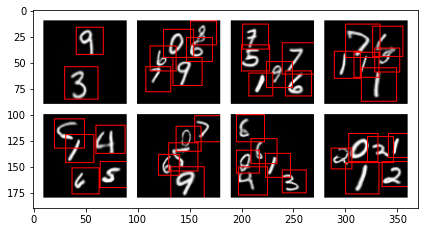

In [91]:
print(output_07.inference.sample_c.sum(dim=0) - count_error)
show_batch(output_07.imgs)

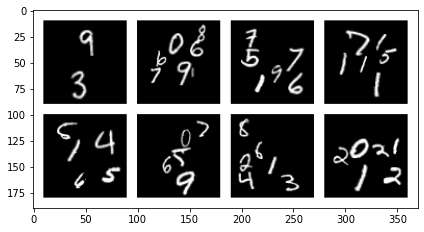

In [80]:
show_batch(imgs_error)

In [67]:
print(count_error)

tensor([2, 6, 6, 6, 5, 5, 6, 6], dtype=torch.uint8)


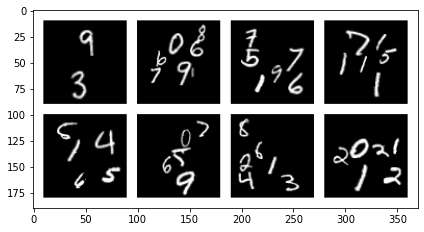

In [68]:
show_batch(imgs_error)

In [69]:
pk = torch.topk(output.inference.prob_map.flatten(start_dim=1), 
                k=8, dim=-1, largest=True, sorted=True)[0]
print(pk.detach().numpy())
print((pk > 0.5).sum(dim=1))

[[9.9981111e-01 9.9977940e-01 7.3970743e-02 4.1005794e-09 3.6937675e-10
  6.6700535e-13 6.2705743e-13 5.8761497e-13]
 [9.9992096e-01 9.9988449e-01 9.9928313e-01 9.9811137e-01 9.8302794e-01
  9.7802663e-01 2.7218504e-02 1.9821555e-03]
 [9.9991357e-01 9.9990809e-01 9.9985147e-01 9.9984670e-01 9.9852872e-01
  9.9446684e-01 5.0717653e-03 6.2179539e-10]
 [9.9985862e-01 9.9978226e-01 9.9806815e-01 9.9517173e-01 9.8163110e-01
  7.3959017e-01 5.8290857e-01 1.8750507e-04]
 [9.9999917e-01 9.9994266e-01 9.9939525e-01 9.9912423e-01 9.9818975e-01
  9.9777216e-01 9.8696971e-01 1.8122009e-10]
 [9.9999797e-01 9.9949372e-01 9.9899822e-01 9.5541579e-01 9.4712406e-01
  4.2297955e-08 3.8534385e-09 1.1754924e-09]
 [9.9991202e-01 9.9981707e-01 9.9690562e-01 9.9009705e-01 9.8928189e-01
  9.8664176e-01 2.8949743e-03 2.9202083e-06]
 [9.9985719e-01 9.9965155e-01 9.9960905e-01 9.9131459e-01 9.8200697e-01
  9.3784070e-01 8.7077314e-01 1.2554079e-01]]
tensor([2, 6, 6, 7, 7, 5, 6, 7])


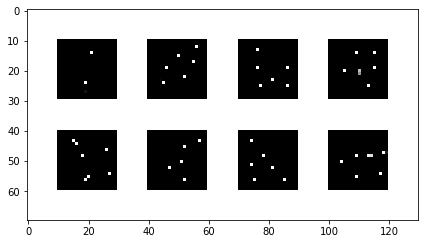

In [71]:
show_batch(output.inference.prob_map)

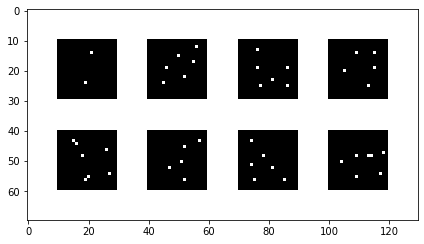

In [72]:
show_batch(output.inference.sample_c_map_before_nms)

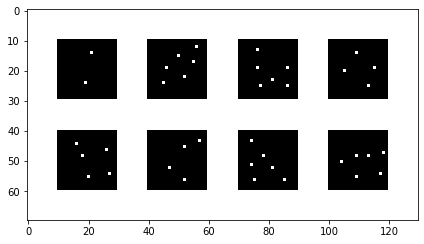

In [73]:
show_batch(output.inference.sample_c_map_after_nms)

In [74]:
print(count_error)
print(output.inference.sample_c.sum(dim=0))

tensor([2, 6, 6, 6, 5, 5, 6, 6], dtype=torch.uint8)
tensor([2., 6., 6., 4., 5., 4., 6., 6.], grad_fn=<SumBackward1>)


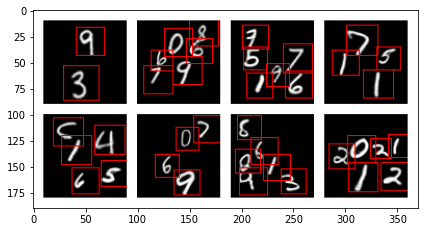

In [75]:
show_batch(output.imgs)

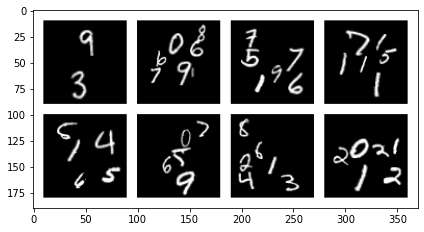

In [76]:
show_batch(imgs_error)

Uninitialized: You must initialize neptune-client first. For more information, please visit: https://github.com/neptune-ai/neptune-client#initialize-neptune

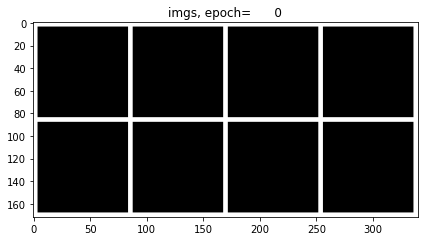

In [35]:
plot_reconstruction_and_inference(output, epoch)

In [20]:
imgs_error[2]

tensor([2, 6, 6, 6, 5, 5, 6, 6], dtype=torch.uint8)

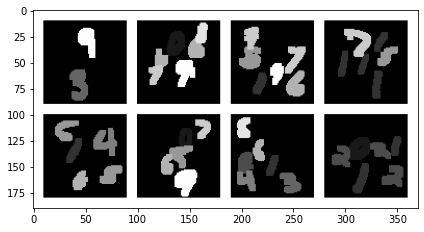

In [19]:
show_batch(imgs_error[1].float())

In [ ]:
wrong_examples=array([ 1, 29, 11, 48, 25, 31, 40, 49])

In [14]:
train_metrics

MetricMiniBatch(loss=0.7688573598861694, mse_tot=0.37468239665031433, reg_tot=0.0, kl_tot=1.9162278175354004, sparsity_tot=0.07124415040016174, kl_zbg=1.4219691024663916e-07, kl_instance=0.7712549567222595, kl_where=0.15441447496414185, kl_logit=22.313631057739258, reg_overlap=0.0, reg_area_obj=0.0, count_prediction=array([-1.]), wrong_examples=array([ 1, 29, 11, 48, 25, 31, 40, 49]), accuracy=0.84, lambda_sparsity=0.10000000149011612, lambda_cell=0.10000000149011612, lambda_mse=0.7905148863792419, f_sparsity=0.2904415428638458, g_sparsity=0.08395248651504517, f_cell=0.421999990940094, g_cell=0.265999972820282, f_mse=0.37468239665031433, g_mse=0.0, fg_fraction_av=0.13395248353481293, n_cell_av=3.859999895095825, similarity_l=4.098819732666016, similarity_w=0.014578231610357761, lambda_logit=3.114684581756592)

python_version() --->  3.8.2
torch.__version__ -->  1.6.0


NVMLError: NVML Shared Library Not Found - GPU usage metrics may not be reported.


https://ui.neptune.ai/dalessioluca/smFISH/e/SMFIS-270
Dataset lenght: 64
img.shape torch.Size([64, 1, 80, 80])
img.dtype torch.float32
img.device cpu
MINIBATCH: img.shapes labels.shape, index.shape -> torch.Size([8, 1, 80, 80]) torch.Size([8]) torch.Size([8])
MINIBATCH: min and max of minibatch tensor(0.0302) tensor(0.7457)
Dataset lenght: 512
img.shape torch.Size([512, 1, 2688, 2688])
img.dtype torch.float32
img.device cpu
MINIBATCH: img.shapes labels.shape, index.shape -> torch.Size([8, 1, 80, 80]) torch.Size([8]) torch.Size([8])
MINIBATCH: min and max of minibatch tensor(0.0302) tensor(0.8647)
simulation type = resume
Each pixel will be segmented 4 times
I am going to process 81 patches
0 out of 1 -> batch_of_imgs.shape = torch.Size([64, 1, 80, 80])
1 out of 1 -> batch_of_imgs.shape = torch.Size([17, 1, 80, 80])
Building the graph with python-igraph
find partition internal
graph_integer_mask cpu torch.int64 torch.Size([300, 300])
gt_integer_mask cpu torch.int64 torch.Size([300, 300]

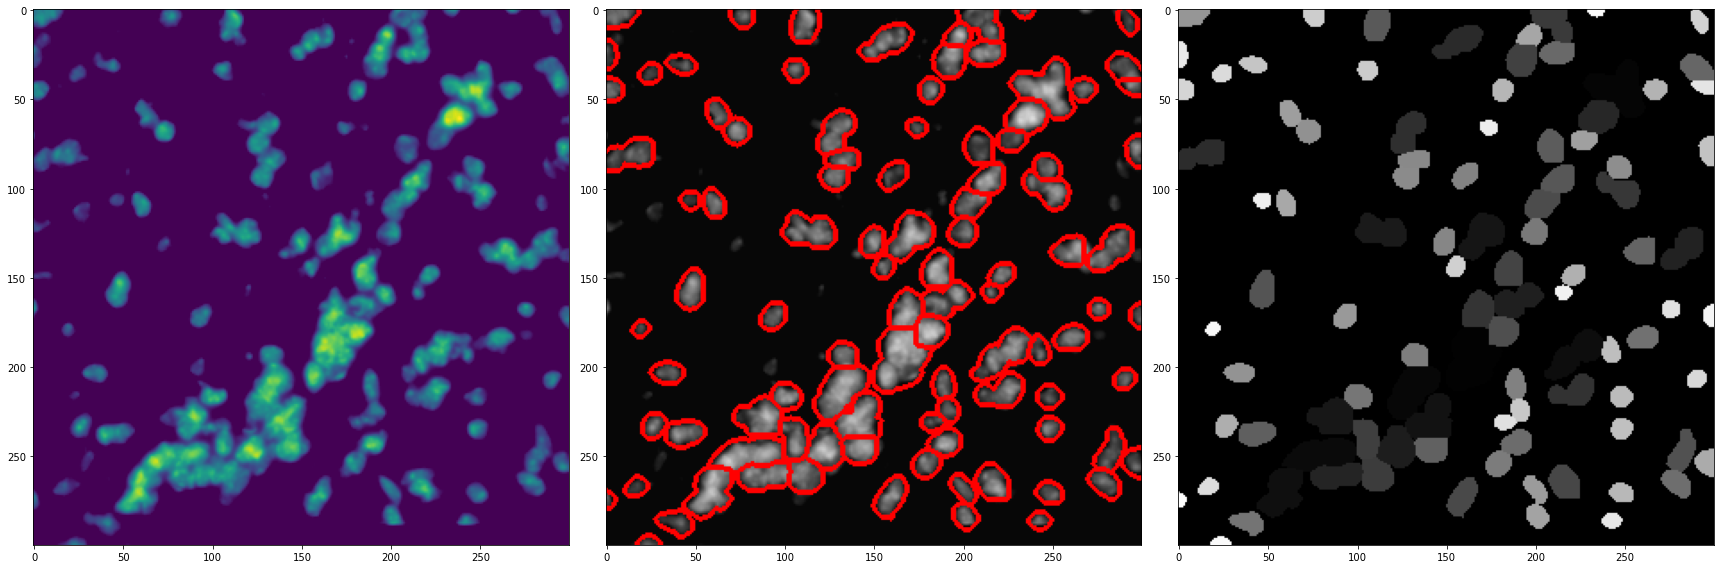

In [2]:
import neptune
from MODULES.utilities_neptune import log_object_as_artifact, log_model_summary, log_img_only, log_dict_metrics
from MODULES.vae_model import *
from MODULES.utilities_visualization import show_batch, plot_tiling, plot_all_from_dictionary, plot_label_contours
from MODULES.utilities_visualization import plot_reconstruction_and_inference, plot_generation, plot_segmentation
from MODULES.utilities_ml import ConditionalRandomCrop, SpecialDataSet, process_one_epoch
from MODULES.graph_clustering import GraphSegmentation
from MODULES.utilities import QC_on_integer_mask, concordance_integer_masks
import skimage.io

# Check versions
import torch
import numpy
from platform import python_version
print("python_version() ---> ", python_version())
print("torch.__version__ --> ", torch.__version__)

# make sure to fix the randomness at the very beginning
torch.manual_seed(0)
numpy.random.seed(0)

params = load_json_as_dict("./ML_parameters.json")

neptune.set_project(params["neptune_project"])
exp: neptune.experiments.Experiment = \
    neptune.create_experiment(params=flatten_dict(params),
                              upload_source_files=["./main.py", "./ML_parameters.json", "./MODULES/vae_parts.py",
                                                   "./MODULES/vae_model.py", "./MODULES/encoders_decoders.py"],
                              upload_stdout=True,
                              upload_stderr=True)

# Get the training and test data
preprocessed = load_obj("./data_train.pt")
img_torch = preprocessed.img.float()
roi_mask_torch = preprocessed.roi_mask.bool()
assert len(img_torch.shape) == len(roi_mask_torch.shape) == 4
# print("GPU GB after opening data ->",torch.cuda.memory_allocated()/1E9)

BATCH_SIZE = params["simulation"]["batch_size"]
SIZE_CROPS = params["input_image"]["size_raw_image"]
N_TEST = params["simulation"]["N_test"]
N_TRAIN = params["simulation"]["N_train"]
conditional_crop_test = ConditionalRandomCrop(desired_w=SIZE_CROPS, desired_h=SIZE_CROPS, 
                                              min_roi_fraction=0.9, n_crops_per_image=N_TEST)

conditional_crop_train = ConditionalRandomCrop(desired_w=SIZE_CROPS, desired_h=SIZE_CROPS, 
                                               min_roi_fraction=0.9, n_crops_per_image=N_TRAIN)

test_data = conditional_crop_test.crop(img=img_torch,
                                       roi_mask=roi_mask_torch)
# print("GPU GB after defining test data ->",torch.cuda.memory_allocated()/1E9)


test_loader = SpecialDataSet(img=test_data,
                             store_in_cuda=False,
                             shuffle=False,
                             drop_last=False,
                             batch_size=BATCH_SIZE)
test_batch_example_fig = test_loader.check_batch()
log_img_only(name="test_batch_example", fig=test_batch_example_fig, experiment=exp)

train_loader = SpecialDataSet(img=img_torch,
                              roi_mask=roi_mask_torch,
                              data_augmentation=conditional_crop_train,
                              store_in_cuda=False,
                              shuffle=True,
                              drop_last=True,
                              batch_size=BATCH_SIZE)
train_batch_example_fig = train_loader.check_batch()
log_img_only(name="train_batch_example", fig=train_batch_example_fig, experiment=exp)
# print("GPU GB after train_loader ->",torch.cuda.memory_allocated()/1E9)

# Make a batch of reference images by cropping the train_data at consecutive locations
reference_imgs_list = []
crop_size = params["input_image"]["size_raw_image"]
for ni in range(2):
    i = 1080 + ni * crop_size
    for nj in range(4):
        j = 2140 + nj * crop_size
        reference_imgs_list.append(img_torch[..., i:i+crop_size, j:j+crop_size])
reference_imgs = torch.cat(reference_imgs_list, dim=-4)
if torch.cuda.is_available():
    reference_imgs = reference_imgs.cuda()
_ = show_batch(reference_imgs,
               n_padding=4,
               figsize=(12, 12),
               title="reference imgs",
               neptune_name="reference_imgs")

# Instantiate model, optimizer and checks
vae = CompositionalVae(params)
log_model_summary(vae)
optimizer = instantiate_optimizer(model=vae, dict_params_optimizer=params["optimizer"])

imgs_out = vae.inference_and_generator.unet.show_grid(reference_imgs)
unet_grid_fig = show_batch(imgs_out[:, 0], normalize_range=(0.0, 1.0), neptune_name="unet_grid")

# Check the constraint dictionary
print("simulation type = "+str(params["simulation"]["type"]))
    
if params["simulation"]["type"] == "scratch":
    
    epoch_restart = -1
    history_dict = {}
    min_test_loss = 999999

elif params["simulation"]["type"] == "resume":
    
    # ckpt = file2ckpt(path="ckpt.pt", device=None)
    ckpt = file2ckpt(path="ckpt.pt", device='cpu')

    load_from_ckpt(ckpt=ckpt,
                   model=vae,
                   optimizer=optimizer,
                   overwrite_member_var=True)

    epoch_restart = ckpt.get('epoch', -1)
    history_dict = ckpt.get('history_dict', {})
    try:
        min_test_loss = min(history_dict.get("test_loss", 999999))
    except:
        min_test_loss = 999999

elif params["simulation"]["type"] == "pretrained":

    # ckpt = file2ckpt(path="ckpt.pt", device=None)
    ckpt = file2ckpt(path="ckpt.pt", device='cpu')

    load_from_ckpt(ckpt=ckpt,
                   model=vae,
                   optimizer=None,
                   overwrite_member_var=False)
       
    epoch_restart = -1
    history_dict = {}
    min_test_loss = 999999
    
else:
    raise Exception("simulation type is NOT recognized")
    
# instantiate the scheduler if necessary    
if params["optimizer"]["scheduler_is_active"]:
    scheduler = instantiate_scheduler(optimizer=optimizer, dict_params_scheduler=params["optimizer"])


TEST_FREQUENCY = params["simulation"]["TEST_FREQUENCY"]
CHECKPOINT_FREQUENCY = params["simulation"]["CHECKPOINT_FREQUENCY"]
NUM_EPOCHS = params["simulation"]["MAX_EPOCHS"]
torch.cuda.empty_cache()
for delta_epoch in range(1, NUM_EPOCHS+1):
    epoch = delta_epoch+epoch_restart    
    
    vae.prob_corr_factor = linear_interpolation(epoch,
                                                values=params["shortcut_prob_corr_factor"]["values"],
                                                times=params["shortcut_prob_corr_factor"]["times"])
    exp.log_metric("prob_corr_factor", vae.prob_corr_factor)
        
    with torch.autograd.set_detect_anomaly(False):
        with torch.enable_grad():
            vae.train()
            train_metrics = process_one_epoch(model=vae, 
                                              dataloader=train_loader, 
                                              optimizer=optimizer, 
                                              verbose=(epoch == 0),
                                              weight_clipper=None,
                                              neptune_experiment=exp,
                                              neptune_prefix="train_")
            print("Train " + train_metrics.pretty_print(epoch))

            if params["optimizer"]["scheduler_is_active"]:
                scheduler.step()
            
            with torch.no_grad():

                history_dict = append_to_dict(source=train_metrics,
                                              destination=history_dict,
                                              prefix_exclude="wrong_examples",
                                              prefix_to_add="train_")

                if (epoch % TEST_FREQUENCY) == 0:

                    vae.eval()
                    test_metrics = process_one_epoch(model=vae, 
                                                     dataloader=test_loader, 
                                                     optimizer=optimizer, 
                                                     verbose=(epoch == 0),
                                                     weight_clipper=None,
                                                     neptune_experiment=exp,
                                                     neptune_prefix="test_")
                    print("Test  "+test_metrics.pretty_print(epoch))
                    history_dict = append_to_dict(source=test_metrics,
                                                  destination=history_dict,
                                                  prefix_exclude="wrong_examples",
                                                  prefix_to_add="test_")
                    
                    output: Output = vae.forward(reference_imgs, draw_image=True, draw_boxes=True, verbose=False)
                    plot_reconstruction_and_inference(output, epoch=epoch, prefix="rec_")
                    reference_n_cells = output.inference.sample_c_map.sum().item()
                    tmp_dict = {"reference_n_cells": reference_n_cells}
                    log_dict_metrics(tmp_dict)
                    history_dict = append_to_dict(source=tmp_dict,
                                                  destination=history_dict)

                    segmentation: Segmentation = vae.segment(batch_imgs=reference_imgs)
                    plot_segmentation(segmentation, epoch=epoch, prefix="seg_")

                    generated: Output = vae.generate(imgs_in=reference_imgs, draw_boxes=True)
                    plot_generation(generated, epoch=epoch, prefix="gen_")

                    test_loss = test_metrics.loss
                    min_test_loss = min(min_test_loss, test_loss)

                    if (test_loss == min_test_loss) or (epoch % CHECKPOINT_FREQUENCY == 0):
                        ckpt = create_ckpt(model=vae,
                                           optimizer=optimizer,
                                           epoch=epoch,
                                           hyperparams_dict=params,
                                           history_dict=history_dict)
                        log_object_as_artifact(name="last_ckpt", obj=ckpt)  # log file into neptune
                        plot_all_from_dictionary(history_dict,
                                                 params,
                                                 test_frequency=TEST_FREQUENCY,
                                                 train_or_test="test",
                                                 verbose=True)
                        plot_all_from_dictionary(history_dict,
                                                 params,
                                                 test_frequency=TEST_FREQUENCY,
                                                 train_or_test="train",
                                                 verbose=True)

# # Check segmentation WITH and WITHOUT tiling to the GROUND_TRUTH
img_to_segment = train_loader.img[0, :, 940:1240, 2140:2440]
roi_mask_to_segment = train_loader.roi_mask[0, :, 940:1240, 2140:2440]
gt_numpy = skimage.io.imread("./ground_truth").astype(numpy.int32)[940:1240, 2140:2440]

# tiling segmentation
tiling: Segmentation = vae.segment_with_tiling(single_img=img_to_segment,
                                               roi_mask=roi_mask_to_segment,
                                               crop_size=None,
                                               stride=(40, 40),
                                               n_objects_max_per_patch=None,
                                               prob_corr_factor=None,
                                               overlap_threshold=None,
                                               radius_nn=10,
                                               batch_size=64)
# log_object_as_artifact(name="tiling", obj=tiling, verbose=True)
tiling_fig = plot_tiling(tiling, neptune_name="tiling_before_graph")

# perform graph analysis
g = GraphSegmentation(tiling, min_fg_prob=0.1, min_edge_weight=0.01, normalize_graph_edges=True)
partition_graph = g.find_partition_leiden(resolution=1.0,
                                          window=None,
                                          min_size=30,
                                          cpm_or_modularity="modularity",
                                          each_cc_separately=False,
                                          n_iterations=10,
                                          initial_membership=None)
g.plot_partition(partition_graph, neptune_name="tiling_after_graph")
graph_integer_mask = g.partition_2_integer_mask(partition_graph)

# qualitative comparison segmentation
simple_integer_mask = QC_on_integer_mask(tiling.integer_mask[0, 0], min_area=30).to(dtype=graph_integer_mask.dtype,
                                                                                    device=graph_integer_mask.device)

gt_integer_mask = torch.from_numpy(QC_on_integer_mask(gt_numpy, min_area=30)).to(dtype=graph_integer_mask.dtype,
                                                                                 device=graph_integer_mask.device)

# compare with ground truth
print("graph_integer_mask", graph_integer_mask.device, graph_integer_mask.dtype, graph_integer_mask.shape)
print("gt_integer_mask", gt_integer_mask.device, gt_integer_mask.dtype, gt_integer_mask.shape)
print("simple_integer_mask", simple_integer_mask.device, simple_integer_mask.dtype, simple_integer_mask.shape)

plot_label_contours(label=gt_integer_mask,
                    image=tiling.raw_image[0, 0],
                    contour_thickness=2,
                    neptune_name="tiling_contours_ground_truth")

plot_label_contours(label=simple_integer_mask,
                    image=tiling.raw_image[0, 0],
                    contour_thickness=2,
                    neptune_name="tiling_contours_simple")

plot_label_contours(label=graph_integer_mask,
                    image=tiling.raw_image[0, 0],
                    contour_thickness=2,
                    neptune_name="tiling_contours_graph")




In [3]:
# quantitative comparison
#simple_vs_gt = concordance_integer_masks(simple_integer_mask, gt_integer_mask)
#graph_vs_gt = concordance_integer_masks(graph_integer_mask, gt_integer_mask)



# FROM HERE. MAKE PLOTS

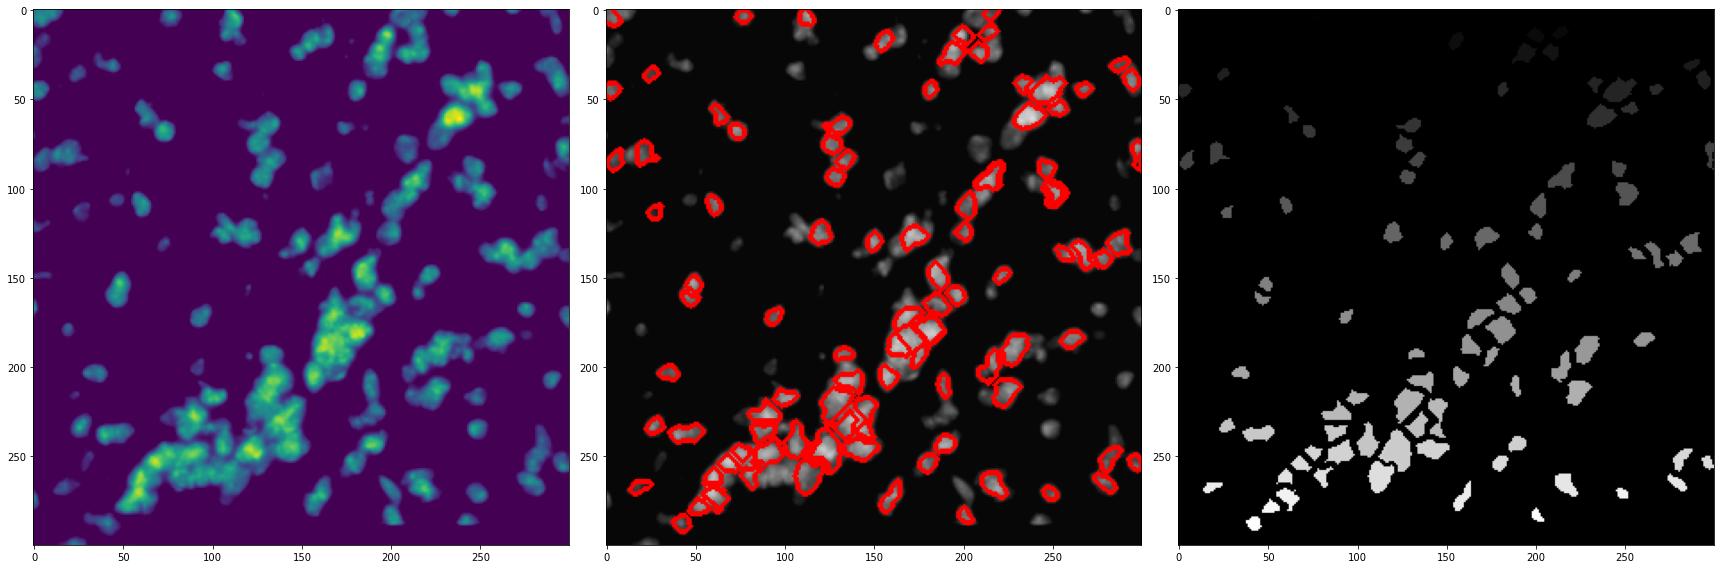

In [7]:
plot_label_contours(label=gt_integer_mask,
                    image=tiling.raw_image[0, 0],
                    contour_thickness=2)

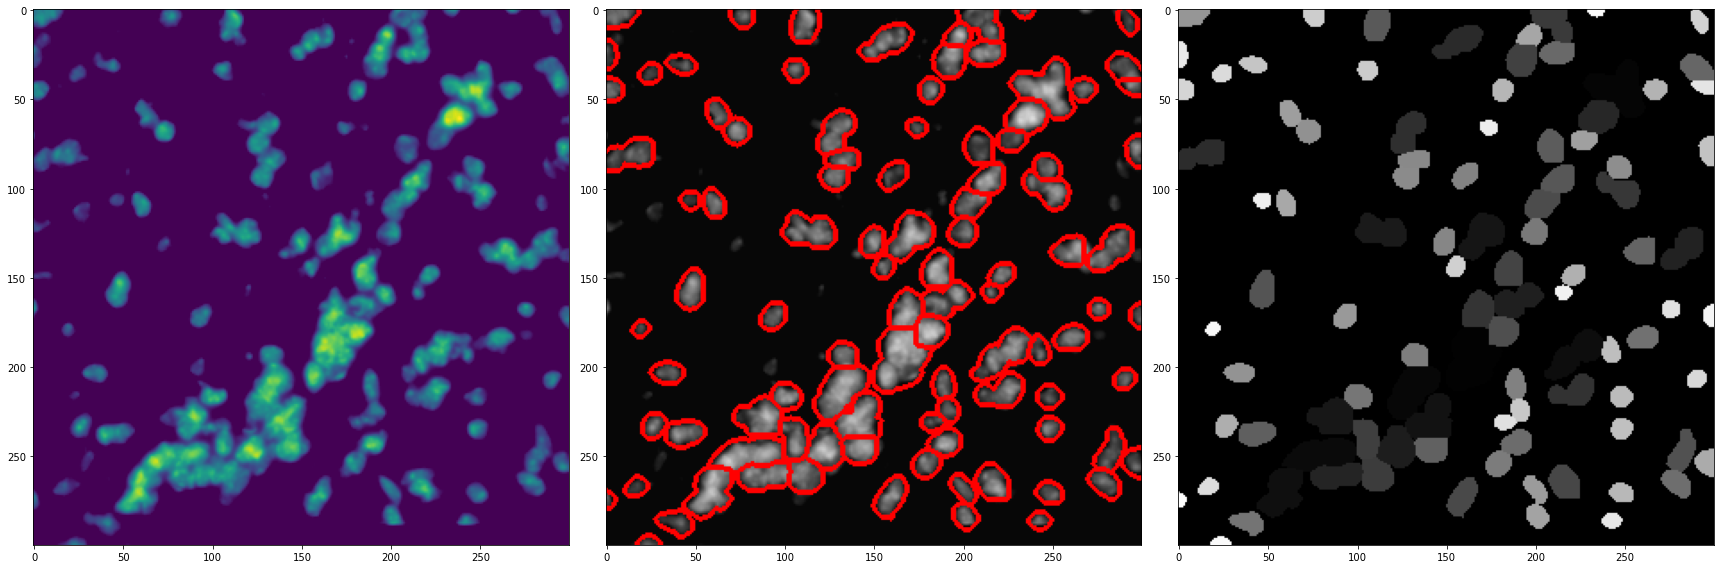

In [6]:
plot_label_contours(label=graph_integer_mask,
                    image=tiling.raw_image[0, 0],
                    contour_thickness=2)

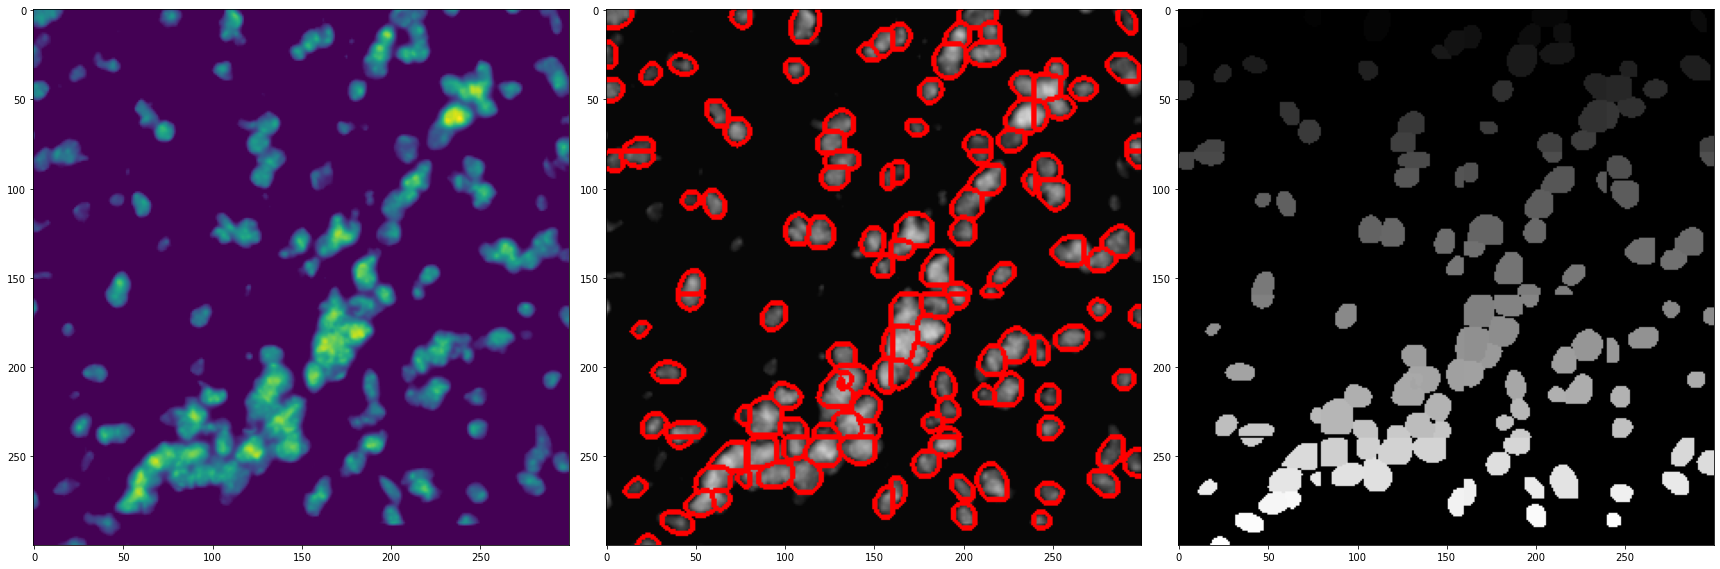

In [5]:
plot_label_contours(label=simple_integer_mask,
                    image=tiling.raw_image[0, 0],
                    contour_thickness=2)

In [8]:
graph_vs_simple = concordance_integer_masks(simple_integer_mask, graph_integer_mask)

In [11]:
graph_vs_simple._fields

('intersection_mask',
 'joint_distribution',
 'mutual_information',
 'delta_n',
 'iou',
 'n_reversible_instances')

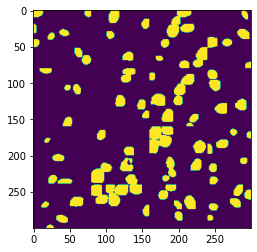

In [10]:
plt.imshow(graph_vs_simple.intersection_mask)

In [15]:
def plot_concordance(concordance, 
                     figsize: tuple = (12, 12),
                     experiment: Optional[neptune.experiments.Experiment] = None,
                     neptune_name: Optional[str] = None):
    
    fig, axes = plt.subplots(figsize=figsize)
    axes.imshow(concordance.intersection_mask, cmap='gray')
    axes.set_title("intersection mask, iou="+str(concordance.iou))
    
    fig.tight_layout()
    if neptune_name is not None:
        log_img_only(name=neptune_name, fig=fig, experiment=experiment)
    plt.close(fig)
    return fig

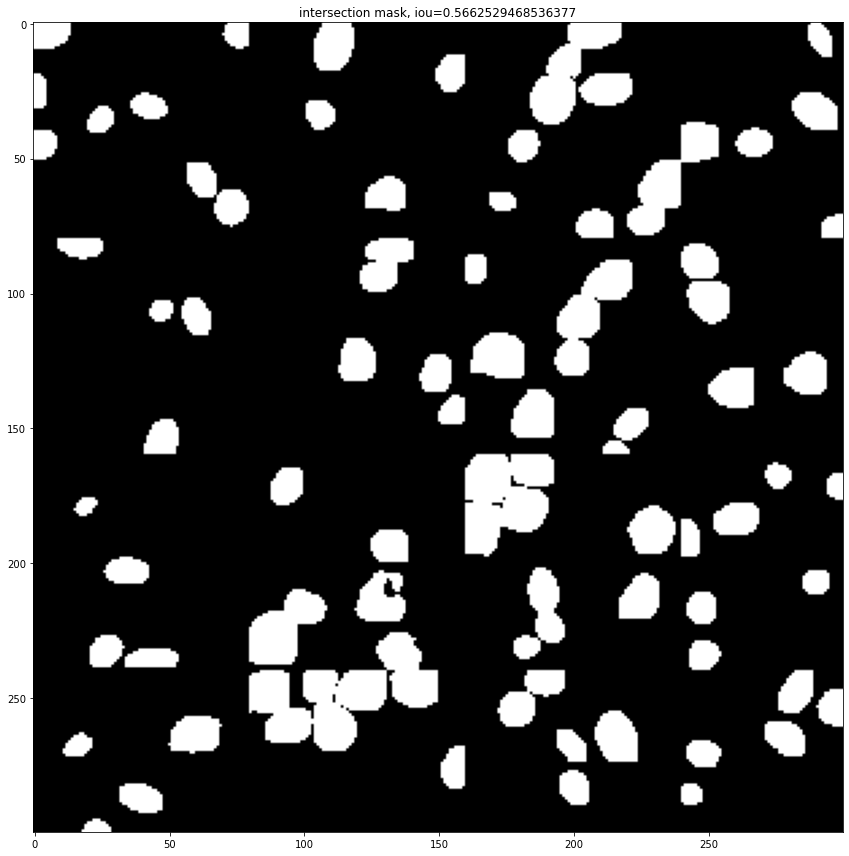

In [16]:
plot_concordance(graph_vs_simple)

In [4]:
#exp.stop()